# Custom Loss Function in PyTorch

[to be edited]
    
    As you might know, that these past few years, there is a high interest to use deep learning model for insurance application. Every model's architectures are the same except on the last output nodes, we apply a log function as similar with the one used in GLM (Generalized Linear Model). But this also would initiate a new problem where we need to apply a loss function that is similar with GLM framework, i.e., log likelihood of the assumed distribution. Luckily there are an example to create such model for GLM with Poisson distribution. But what about Gamma distribution or even Tweedie distribution. Shouldn't these 2 distribution also have their own built-in function in PyTorch ? 

This notebook will try to create the Gamma and Tweedie log likelihood function that theoretically can mimick the GLM model for said distribution.  

In [ ]:
# General Data Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# GLM Model
import statsmodels.api as sm
from statsmodels.formula.api import glm
from sklearn.metrics import mean_gamma_deviance
from scipy.stats import gamma 

# Neural Network
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
np.random.seed(108)
n_obs = 100_000

model_df = pd.DataFrame({
    'variable_1' : np.random.choice(a=['a', 'b', 'c'], size=n_obs),
    'variable_2' : np.random.uniform(low=0, high=20, size=n_obs),
    'variable_3' : np.random.normal(loc = 0, scale = 1, size = n_obs),
    'exposure' : np.round(np.random.uniform(low=0.2, high=1, size=n_obs),4),
    })
model_df['lambda'] = np.exp(
    2.2 + 
    model_df['variable_1'].map({'a': 0.4, 'b': -0.3, 'c': 0.8}) - 
    0.2*model_df['variable_2'] + 
    1.2*np.cos(model_df['variable_3']) + 
    np.log(model_df['exposure'])
)

model_df['claim_count'] = np.random.poisson(lam = model_df['lambda'])

# Claim Amount
model_df['gamma_shape'] = (
    0.00008 + 
    model_df['variable_1'].map({'a': 0.000041, 'b': 0.00008, 'c': 0.00002}) + 
    0.00009*model_df['variable_2'] + 
    0.00006*np.cosh(model_df['variable_3'])
)**-1 * model_df['claim_count']
model_df.loc[(model_df['claim_count'] == 0), 'gamma_shape'] = 0

model_df['gamma_mean'] = model_df['gamma_shape'] * 1.8 # we choose a dispersion parameter of 1.8
model_df['total_claim_amount'] = np.random.gamma(shape = model_df['gamma_shape'] , scale = 1.8)
model_df

,variable_1,variable_2,variable_3,exposure,lambda,claim_count,gamma_shape,gamma_mean,total_claim_amount
0,b,7.563060,-0.302359,0.3453,1.599371,0,0.000000,0.000000,0.000000
1,c,5.419909,-0.041613,0.7115,16.032204,18,85.754554,154.358197,166.256001
2,c,4.864539,-0.013409,0.9464,23.852626,21,79.655300,143.379540,157.247030
3,c,12.394991,-1.153324,0.3808,1.042959,0,0.000000,0.000000,0.000000
4,a,1.471028,-0.435920,0.7594,22.608960,41,76.414330,137.545793,124.280638
...,...,...,...,...,...,...,...,...,...
99995,c,14.483830,-1.442644,0.6825,0.882147,6,108.394751,195.110552,168.582535
99996,c,17.158324,-1.057541,0.3563,0.417101,0,0.000000,0.000000,0.000000
99997,b,10.751592,-0.409207,0.2165,0.506840,0,0.000000,0.000000,0.000000
99998,a,15.931183,-0.500684,0.7192,1.146660,0,0.000000,0.000000,0.000000


In [ ]:
model_df[model_df['claim_count']>0].describe()

,variable_2,variable_3,exposure,lambda,claim_count,gamma_shape,gamma_mean,total_claim_amount
count,72760.000000,72760.000000,72760.000000,72760.000000,72760.000000,72760.000000,72760.000000,72760.000000
mean,8.197068,-0.006156,0.625219,6.008452,6.255333,430.306529,774.551752,774.671274
std,5.302430,0.896793,0.226405,7.340116,7.593127,328.718312,591.692961,593.426074
min,0.000395,-4.432830,0.200000,0.024610,1.000000,44.051021,79.291837,65.595381
25%,3.685046,-0.610683,0.435900,1.409184,2.000000,196.243105,353.237589,352.484409
50%,7.595004,-0.003689,0.635600,3.298428,3.000000,330.941808,595.695255,595.803773
75%,12.207833,0.597575,0.821800,7.623772,8.000000,584.051632,1051.292938,1052.873342
max,19.999914,4.259687,1.000000,64.247180,72.000000,4131.848257,7437.326863,7525.236280


In [ ]:
sev_df = model_df[model_df['claim_count']>0][['variable_1', 'variable_2', 'variable_3', 'claim_count','gamma_shape', 'gamma_mean', 'total_claim_amount']].copy()
sev_df

,variable_1,variable_2,variable_3,claim_count,gamma_shape,gamma_mean,total_claim_amount
1,c,5.419909,-0.041613,18,85.754554,154.358197,166.256001
2,c,4.864539,-0.013409,21,79.655300,143.379540,157.247030
4,a,1.471028,-0.435920,41,76.414330,137.545793,124.280638
5,c,3.129145,-0.129539,25,90.471706,162.849071,208.726049
7,b,3.774781,-0.410134,10,177.038868,318.669962,317.055216
...,...,...,...,...,...,...,...
99992,c,1.518468,-0.216082,28,119.819120,215.674417,231.753575
99993,c,15.338840,-1.447809,1,619.133045,1114.439480,1077.850428
99994,a,7.024683,-0.432526,10,122.111767,219.801180,209.122312
99995,c,14.483830,-1.442644,6,108.394751,195.110552,168.582535


In [ ]:
sev_df.groupby('variable_1').describe().T

variable_1                           a             b             c
variable_2         count  25006.000000  20620.000000  27134.000000
                   mean       8.232719      7.446838      8.734336
                   std        5.302219      5.069335      5.407358
                   min        0.001318      0.000485      0.000395
                   25%        3.731142      3.192252      4.137769
                   50%        7.668826      6.680481      8.356677
                   75%       12.255026     11.044487     12.976246
                   max       19.999223     19.994497     19.999914
variable_3         count  25006.000000  20620.000000  27134.000000
                   mean       0.001515     -0.012818     -0.008164
                   std        0.897399      0.866060      0.918898
                   min       -4.432830     -4.037928     -3.996666
                   25%       -0.606828     -0.593464     -0.630436
                   50%        0.007743     -0.016311     -0.004380
                   75%        0.610190      0.575217      0.604566
                   max        4.046620      4.259687      3.726595
claim_count        count  25006.000000  20620.000000  27134.000000
                   mean       6.128929      3.727692      8.292659
                   std        6.719293      3.602571      9.701332
                   min        1.000000      1.000000      1.000000
                   25%        2.000000      1.000000      2.000000
                   50%        4.000000      2.000000      5.000000
                   75%        8.000000      5.000000     11.000000
                   max       60.000000     29.000000     72.000000
gamma_shape        count  25006.000000  20620.000000  27134.000000
                   mean     414.377875    581.984984    329.720628
                   std      305.310840    385.733462    250.898303
                   min       54.936857     78.762956     44.051021
                   25%      194.741381    307.384286    147.019646
                   50%      319.433899    500.898321    247.335100
                   75%      563.182996    736.628539    457.298802
                   max     3827.574709   4131.848257   2923.958133
gamma_mean         count  25006.000000  20620.000000  27134.000000
                   mean     745.880175   1047.572971    593.497131
                   std      549.559511    694.320232    451.616945
                   min       98.886343    141.773320     79.291837
                   25%      350.534485    553.291715    264.635363
                   50%      574.981018    901.616978    445.203180
                   75%     1013.729392   1325.931370    823.137843
                   max     6889.634476   7437.326863   5263.124639
total_claim_amount count  25006.000000  20620.000000  27134.000000
                   mean     746.071661   1047.663894    593.572065
                   std      552.093090    695.831023    453.097057
                   min       91.566531    140.066666     65.595381
                   25%      352.288798    553.565412    265.065973
                   50%      575.868692    895.633274    443.890048
                   75%     1013.958573   1328.375856    825.314338
                   max     6897.920816   7525.236280   5282.331428

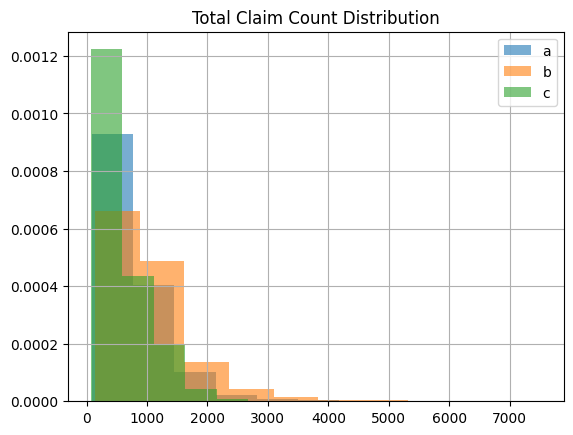

In [ ]:
sev_df.groupby('variable_1')['total_claim_amount'].hist(legend=True, alpha=0.6, density = True)
plt.title('Total Claim Count Distribution')
plt.show()

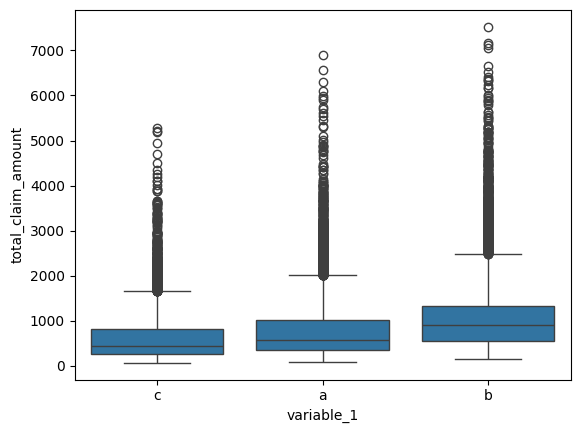

In [ ]:
sns.boxplot(x = sev_df['variable_1'], y = sev_df['total_claim_amount'])
plt.show()

In [ ]:
print(f'The Negative Log Likelihood of the data is {-1 * np.sum(gamma.logpdf(sev_df['total_claim_amount'], a = sev_df['gamma_shape'], loc=0, scale=1.6)):.4f}')

The Negative Log Likelihood of the data is 584095.5042


# Custom Loss Function (NegativeLogLikelihood Gamma)

We begin by defining gamma Probability Distribution Function (PDF) as follow:
$$
f(y; \alpha, \beta) := \frac{\beta^\alpha y^{\alpha-1} \exp{(-\beta y)}}{\Gamma(\alpha)}
$$

with $\alpha$ is the shape parameter and $\beta$ is the scale parameter in our Python code. Therefore we have that:
$$
E[Y] := \mu = \alpha \beta \quad \text{and} \quad \text{Var}(Y) := \nu = \alpha \beta^2 = \mu \beta = \frac{\mu^2}{\alpha}
$$
However we are going to reparametrize this function such that $\mu = \alpha \beta$ and $\nu = \frac{\mu^2}{\alpha}$. From this we have
$$
\alpha := \frac{\mu^2}{\nu}\quad \text{and} \quad \beta := \nu
$$
Which helps us to rewrite the above equation into:
$$
f(y; \mu, \nu) := \frac{\nu^{\frac{\mu^2}{\nu}} y^{\frac{\mu^2}{\nu}-1} \exp{(-\nu y)}}{\Gamma(\frac{\mu^2}{\nu})}
$$ 

Since we want to minimize the sum of negative log likelihood of $f(y_i; \mu, \nu) $ we can write the equation to be:
$$
\begin{aligned}
\sum_{i=1}^{n}\log{f(y_i; \mu, \nu)} &:= n \frac{\mu^2}{\nu} \log{\nu} + \left(\frac{\mu^2}{\nu}-1\right) \sum_{i=1}^{n} \log{y_i} - \nu \sum_{i=1}^{n} y_i - n \log{\Gamma\left(\frac{\mu^2}{\nu}\right)} \\
&= n \left(\frac{\mu^2}{\nu} \log{\nu} -  \log{\Gamma\left(\frac{\mu^2}{\nu}\right)} \right)+ \left(\frac{\mu^2}{\nu}-1\right) \sum_{i=1}^{n} \log{y_i} - \nu \sum_{i=1}^{n} y_i
\end{aligned}
$$

Note that in doing GLM, the output of the model is the mean of the assumed distribution. In above equation, it is clear that we also need to estimate $\nu$